In [1]:
import math
import os
import os.path as osp
from glob import glob
from io import StringIO

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import py3Dmol
import seaborn as sns
import torch
from Bio.PDB import Atom, Chain
from Bio.PDB import Model as PDBModel
from Bio.PDB import Residue, Structure
from Bio.PDB.mmcifio import MMCIFIO
from matplotlib.patches import Circle, FancyArrowPatch, FancyBboxPatch, Patch
from tensorboard.backend.event_processing import event_accumulator

from model import PytorchLightningModule

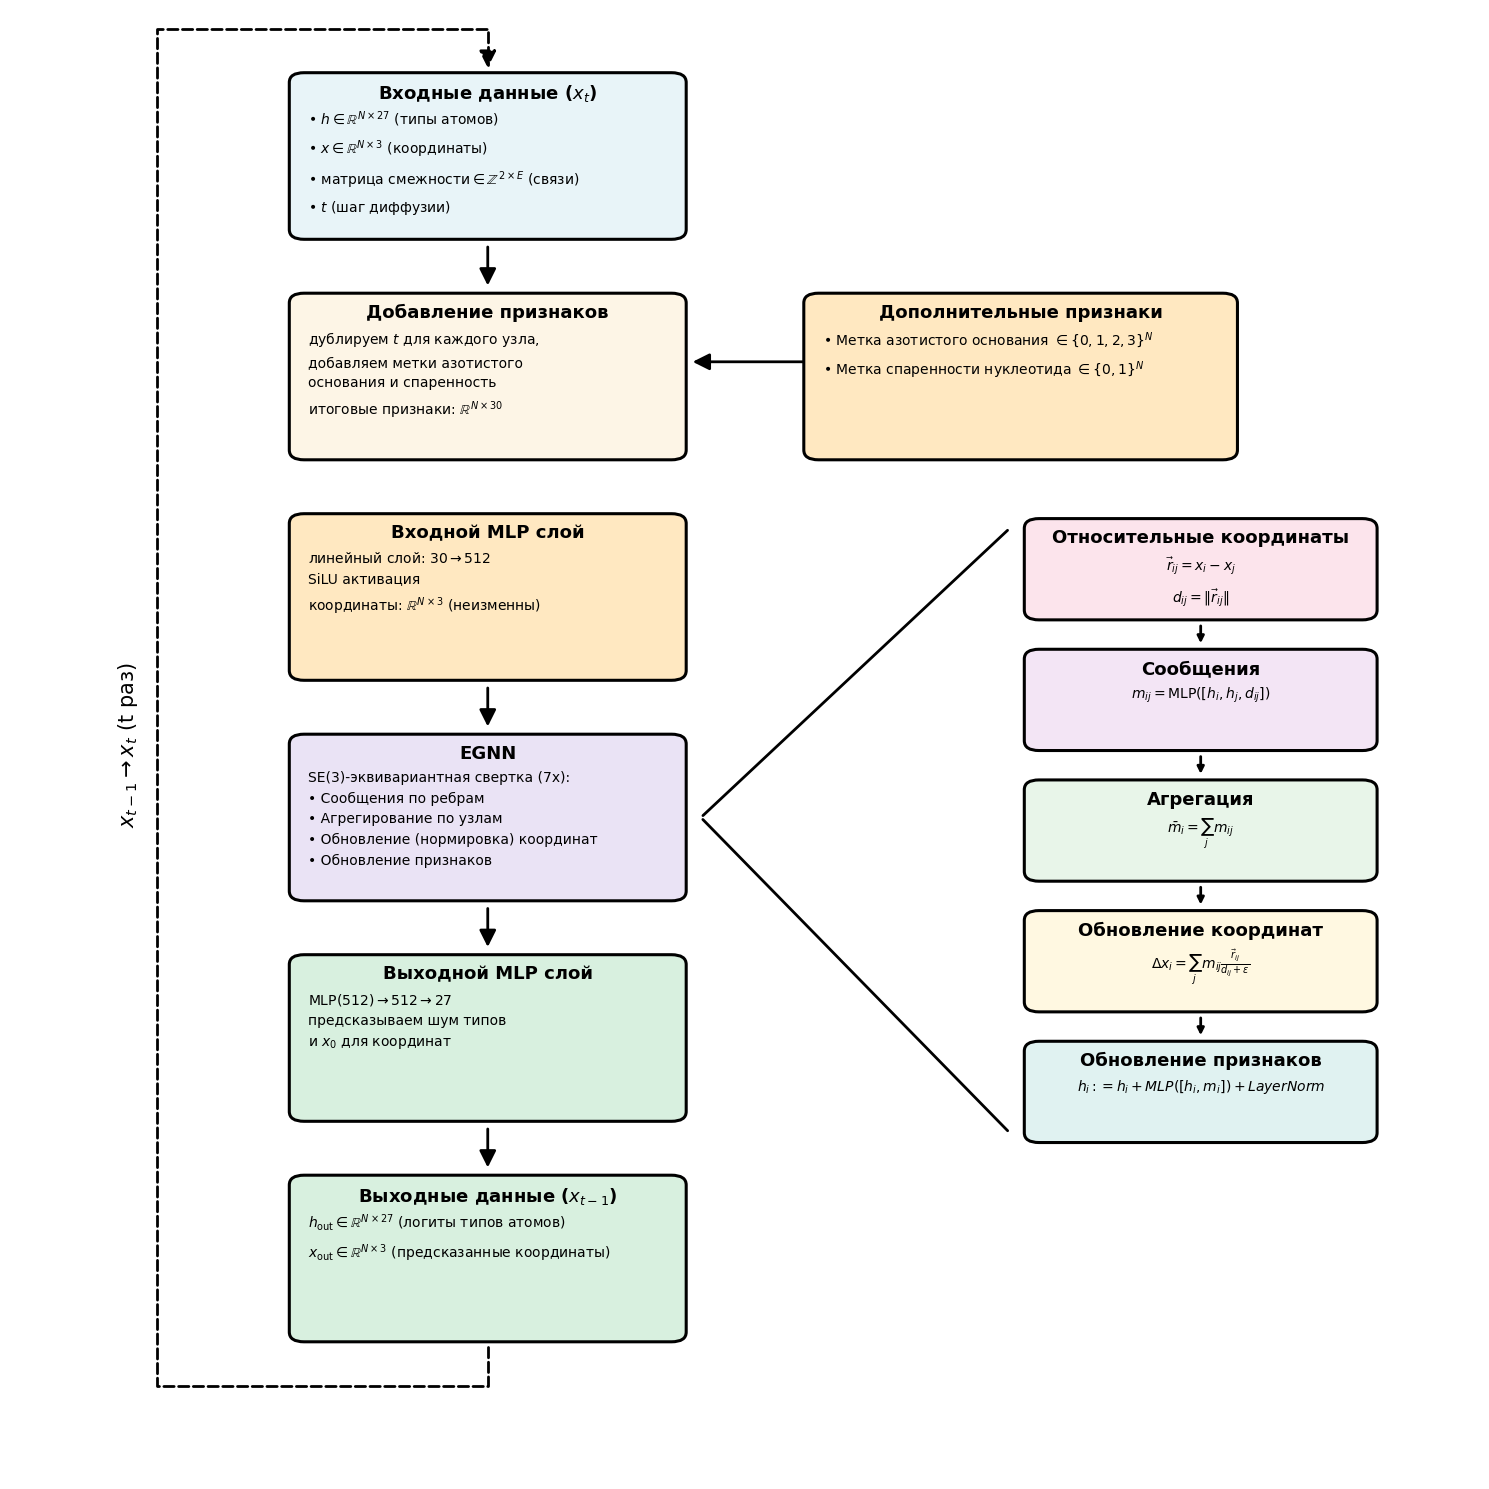

In [2]:
plt.rcParams['font.family'] = 'DejaVu Sans'

MAX_X = 15
MAX_Y = MAX_X * 1.5

fig, ax = plt.subplots(figsize=(15, 15))

ax.set_xlim(0, MAX_X)
ax.set_ylim(0, MAX_Y)
ax.axis('off')

palette = {
    'input': '#E8F4F8',
    'pre': '#FDF5E6',
    'embed': '#FFE8C1',
    'equiv': '#EAE3F5',
    'output': '#D8F0DF',
    'detail': '#FFF8D6',
    'feature': '#F0F8FF'
}


def draw_box(x, y, width, height, title, desc, desc_align, color):
    ax.add_patch(FancyBboxPatch(
        (x, y),
        width,
        height,
        boxstyle='round,pad=0.15',
        facecolor=color,
        linewidth=2.2
    ))

    # Title
    ax.text(
        x + width/2,
        y + height,
        title,
        ha='center',
        va='top',
        fontsize=13,
        fontweight='bold'
    )
    # Description
    if desc_align == 'left':
        ax.text(
            x + width*0.01,
            y + height - 0.4,
            desc,
            ha=desc_align,
            va='top',
            linespacing=1.6
        )
    else:
        ax.text(
            x + width/2,
            y + height - 0.4,
            desc,
            ha=desc_align,
            va='top',
            linespacing=1.6
        )


def draw_arrow(x1, y1, x2, y2):
    arrow = FancyArrowPatch(
        (x1, y1),
        (x2, y2),
        arrowstyle='-|>',
        linewidth=2,
        mutation_scale=25,  # Arrow head size
        color='black'
    )
    ax.add_patch(arrow)


# ========== MAIN FLOW (left column) ==========
main_x = MAX_X * 0.2
main_y = MAX_Y * 0.85
main_width = MAX_X * 0.25
main_height = MAX_Y * 0.1
arrow_length = MAX_Y * 0.05

detail_x = MAX_X * 0.7
detail_y = MAX_Y * 0.68
detail_width = MAX_X * 0.22

# Input
draw_box(
    main_x,
    main_y,
    main_width,
    main_height,
    r'Входные данные ($x_t$)',
    r'• $h \in \mathbb{R}^{N \times 27}$ (типы атомов)' + '\n' +
    r'• $x \in \mathbb{R}^{N \times 3}$ (координаты)' + '\n' +
    r'• $\text{матрица смежности} \in \mathbb{Z}^{2 \times E}$ (связи)' + '\n' +
    r'• $t$ (шаг диффузии)',
    'left',
    palette['input']
)
draw_arrow(
    main_x + main_width/2,
    main_y-MAX_Y*0.01,
    main_x + main_width/2,
    main_y-MAX_Y*0.04
)

# Feature augmentation
draw_box(
    main_x,
    main_y-(main_height+arrow_length),
    main_width,
    main_height,
    'Добавление признаков',
    'дублируем $t$ для каждого узла,\nдобавляем метки азотистого\nоснования и спаренность\n' +
    r'итоговые признаки: $\mathbb{R}^{N \times 30}$',
    'left',
    palette['pre']
)
draw_arrow(
    detail_x,
    MAX_Y*0.76,
    main_x + main_width*1.05,
    MAX_Y*0.76
)
draw_box(
    main_x+main_width+MAX_X*0.1,
    main_y-(main_height+arrow_length),
    main_width*1.1,
    main_height,
    'Дополнительные признаки',
    r'• Метка азотистого основания $\in \{0, 1, 2, 3\}^N$' + '\n' +
    r'• Метка спаренности нуклеотида $\in \{0, 1\}^N$',
    'left',
    palette['embed']
)
draw_arrow(
    main_x + main_width/2,
    main_y-(main_height+arrow_length)*2+MAX_Y*0.04,
    main_x + main_width/2,
    main_y-(main_height+arrow_length)*2+MAX_Y*0.04-arrow_length
)

# Embedding
draw_box(
    main_x,
    main_y-(main_height+arrow_length)*2,
    main_width,
    main_height,
    'Входной MLP слой',
    r'линейный слой: $30 \rightarrow 512$' + '\n' +
    'SiLU активация\n' +
    r'координаты: $\mathbb{R}^{N \times 3}$ (неизменны)',
    'left',
    palette['embed']
)
draw_arrow(
    main_x + main_width/2,
    MAX_Y*0.54,
    main_x + main_width/2,
    MAX_Y*0.51
)

# Equivariant blocks
draw_box(
    main_x,
    main_y-(main_height+arrow_length)*3,
    main_width,
    main_height,
    'EGNN',
    'SE(3)-эквивариантная свертка (7x):\n' +
    '• Сообщения по ребрам\n' +
    '• Агрегирование по узлам\n' +
    '• Обновление (нормировка) координат\n' +
    '• Обновление признаков',
    'left',
    palette['equiv']
)
draw_arrow(
    main_x + main_width/2,
    MAX_Y*0.39,
    main_x + main_width/2,
    MAX_Y*0.36
)

# Output embedding
draw_box(
    main_x,
    main_y-(main_height+arrow_length)*4,
    main_width,
    main_height,
    'Выходной MLP слой',
    r'$\text{MLP}(512) \rightarrow 512 \rightarrow 27$' + '\n' +
    'предсказываем шум типов' + '\n' +
    r'и $x_0$ для координат',
    'left',
    palette['output']
)
draw_arrow(
    main_x + main_width/2,
    MAX_Y*0.24,
    main_x + main_width/2,
    MAX_Y*0.21
)

# Output
draw_box(
    main_x,
    main_y-(main_height+arrow_length)*5,
    main_width,
    main_height,
    r'Выходные данные ($x_{t-1}$)',
    r'$h_{\text{out}} \in \mathbb{R}^{N \times 27}$ (логиты типов атомов)' + '\n' +
    r'$x_{\text{out}} \in \mathbb{R}^{N \times 3}$ (предсказанные координаты)',
    'left',
    palette['output']
)

# ========== DETAIL OPERATIONS (right column) ==========
detail_steps = [
    ('Относительные координаты',
     r'$\vec{r}_{ij} = x_i - x_j$' + '\n' + r'$d_{ij} = \|\vec{r}_{ij}\|$'),
    ('Сообщения',
     r'$m_{ij} = \text{MLP}([h_i, h_j, d_{ij}])$'),
    ('Агрегация',
     r'$\bar{m}_i = \sum_j m_{ij}$'),
    ('Обновление координат',
     r'$\Delta x_i = \sum_j m_{ij} \frac{\vec{r}_{ij}}{d_{ij} + \epsilon}$'),
    ('Обновление признаков',
     '$h_i := h_i + MLP([h_i, m_i])+LayerNorm$')
]

detail_palette_steps = ['#FCE4EC', '#F3E5F5', '#E8F5E9', '#FFF8E1', '#E0F2F1']
step_height = 2

for idx, (step_title, step_desc) in enumerate(detail_steps):
    y = detail_y - (idx + 1) * step_height
    draw_box(
        detail_x,
        y,
        detail_width,
        step_height - 0.75,
        step_title,
        step_desc,
        'center',
        detail_palette_steps[idx]
    )
    # Arrow between steps
    if idx < len(detail_steps) - 1:
        ax.add_patch(FancyArrowPatch(
            (detail_x + detail_width/2, y-0.2),
            (detail_x + detail_width/2, y-0.55),
            linewidth=2,
            arrowstyle='-|>',
            mutation_scale=10,  # Arrow head size
            color='black'
        ))


# ============ Lines connecting EGNN block to its details ============
egnn_y_bottom = MAX_Y * 0.4
egnn_height = MAX_Y * 0.1
egnn_x_right = main_x + main_width + MAX_X*0.02
egnn_y_center = egnn_y_bottom + egnn_height/2

rel_coords_y_bottom = detail_y - step_height
rel_coords_height = step_height - 0.75
rel_coords_y_top = rel_coords_y_bottom + rel_coords_height

update_feat_y_bottom = detail_y - 5*step_height

# Line to top block
ax.add_patch(FancyArrowPatch(
    (egnn_x_right, egnn_y_center),
    (detail_x - MAX_X*0.02, rel_coords_y_top),
    linewidth=2,
    arrowstyle='-'  # Draw a line, not an arrow
))

# Line to bottom block
ax.add_patch(FancyArrowPatch(
    (egnn_x_right, egnn_y_center),
    (detail_x - MAX_X*0.02, update_feat_y_bottom),
    linewidth=2,
    arrowstyle='-'  # Draw a line, not an arrow
))


# ============ Diffusion arrow ============
out_block_y = MAX_Y * 0.09
out_block_x_center = main_x + main_width/2

in_block_y = MAX_Y * 0.86
in_block_height = MAX_Y * 0.1
in_block_top_y = in_block_y + in_block_height
in_block_x_center = main_x + main_width/2

arrow_path_data = [
    (mpath.Path.MOVETO, (out_block_x_center, out_block_y)),  # Start from bottom of Output block
    (mpath.Path.LINETO, (out_block_x_center, out_block_y - 0.6)),  # Go down
    (mpath.Path.LINETO, (1.5, out_block_y - 0.6)),  # Go left
    (mpath.Path.LINETO, (1.5, in_block_top_y + 0.6)),  # Go up
    (mpath.Path.LINETO, (in_block_x_center, in_block_top_y + 0.6)),  # Go right
    (mpath.Path.LINETO, (in_block_x_center, in_block_top_y)),  # Connect to top of Input block
]
codes, verts = zip(*arrow_path_data)
arrow_path = mpath.Path(verts, codes)

ax.add_patch(FancyArrowPatch(
    path=arrow_path,
    arrowstyle='-|>',
    linewidth=2,
    mutation_scale=25,  # Arrow head size
    color='black',
    linestyle='--'
))
ax.text(
    1.2,
    MAX_Y/2,
    r'$x_{t-1} \rightarrow x_t \text{ (t раз)}$',
    fontsize=15,
    rotation=90,
    ha='center',
    va='center'
)

plt.tight_layout()
diagram_path = osp.join('..', 'data', 'model.png')
plt.savefig(diagram_path, dpi=300, bbox_inches='tight')
plt.show()

In [4]:
def load_event_accumulator(path):
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={'scalars': 0, 'histograms': 0, 'images': 0}
    )
    ea.Reload()
    return ea


def scalars_to_dataframe(ea, tag):
    rows = []
    for s in ea.Scalars(tag):
        rows.append((s.step, s.value))
    return pd.DataFrame(rows, columns=['step', 'value'])


run_filename = 'dim256_steps200'
run_path = osp.join('..', 'logs', run_filename)
event_files = glob(osp.join(run_path, 'events.*'))

dfs = []
for ef in event_files:
    ea = load_event_accumulator(ef)
    for tag in ea.Tags()['scalars']:
        df = scalars_to_dataframe(ea, tag)
        df['tag'] = tag
        dfs.append(df)

scalars = pd.concat(dfs, ignore_index=True)
epochs = scalars[scalars['tag'] == 'epoch'][['step', 'value']]
epochs['value'] = epochs['value'].astype(int)
scalars = scalars[(scalars['tag'] != 'hp_metric') & (scalars['tag'] != 'epoch')]
scalars_by_epoch = scalars \
    .merge(epochs, on='step') \
    .rename(columns={'value_x': 'value', 'value_y': 'epoch'}) \
    .drop(columns=['step']) \
    .drop_duplicates()[['epoch', 'tag', 'value']] \
    .reset_index(drop=True)
wide_scalars = scalars_by_epoch.pivot(index='epoch', columns='tag', values='value')
wide_scalars

tag,test_combined_score,test_kappa,test_rmse,train_kappa,train_loss,train_rmse,val_combined_score,val_kappa,val_rmse
epoch,,,,,,,,,
0,NaN,NaN,NaN,0.532181,15.295619,0.791459,3.864496,0.400569,4.264501
1,NaN,NaN,NaN,0.786744,7.335711,1.344993,3.369455,0.640433,4.009131
2,NaN,NaN,NaN,0.779045,5.379347,0.661709,3.268804,0.649869,3.918370
3,NaN,NaN,NaN,0.807773,6.258232,0.701834,3.591882,0.699670,4.292143
4,NaN,NaN,NaN,0.762024,7.213580,0.583863,3.273285,0.689792,3.965078
...,...,...,...,...,...,...,...,...,...
153,NaN,NaN,NaN,0.787805,8.349100,0.599162,1.772234,0.698317,2.471557
154,NaN,NaN,NaN,0.764722,6.287951,0.531306,1.706485,0.697308,2.403892
155,NaN,NaN,NaN,0.794912,6.237788,0.665739,1.731193,0.699063,2.431805


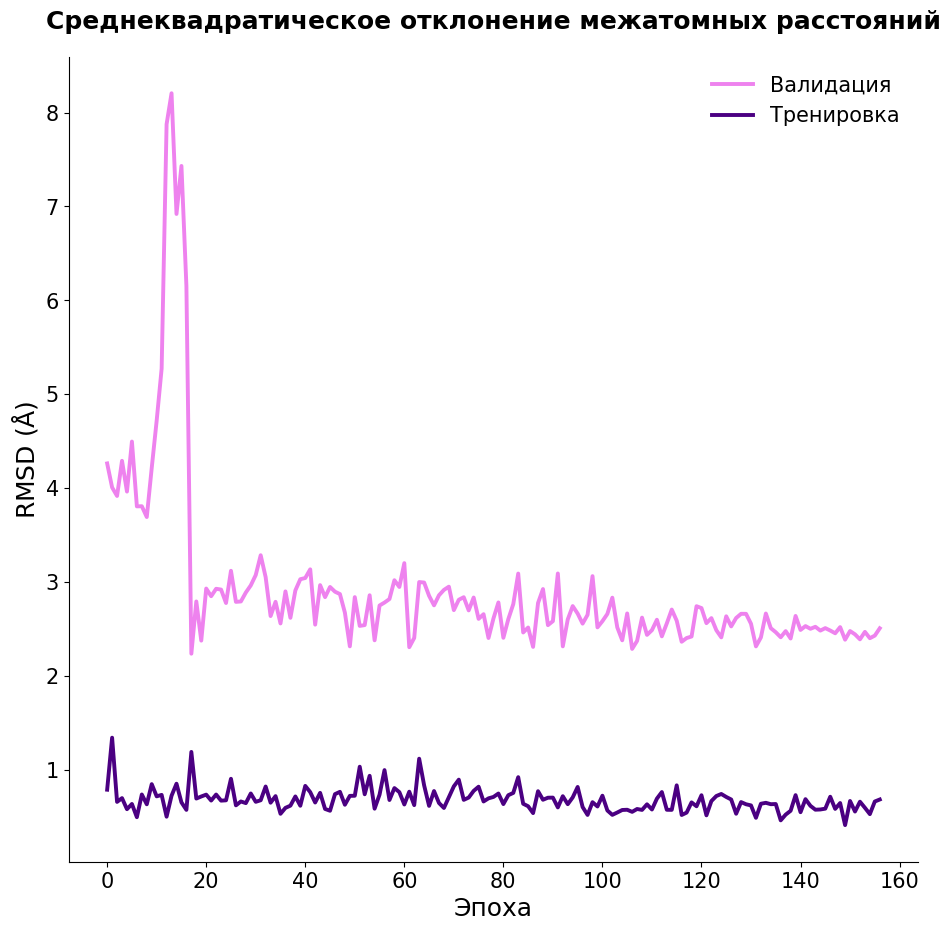

In [5]:
plt.rcParams['font.family'] = 'DejaVu Sans'

fig, ax = plt.subplots(figsize=(10, 10), sharex=False)

ax.tick_params(axis='both', labelsize=15)
sns.despine(top=True, right=True)

rmse_metrics = scalars_by_epoch[scalars_by_epoch['tag'].isin(['train_rmse', 'val_rmse'])].copy()
rmse_metrics['tag'] = rmse_metrics['tag'].map({'train_rmse': 'Тренировка', 'val_rmse': 'Валидация'})
sns.lineplot(
    data=rmse_metrics,
    x='epoch',
    y='value',
    hue='tag',
    palette=['violet', 'indigo'],
    linewidth=2.8
)
plt.title(
    'Среднеквадратическое отклонение межатомных расстояний',
    fontsize=18,
    fontweight='bold',
    pad=20
)
plt.xlabel('Эпоха', fontsize=18)
plt.ylabel(r'RMSD ($\mathrm{\AA}$)', fontsize=18)
plt.legend(title=None, fontsize=15, loc='upper right', frameon=False)

fig.tight_layout(pad=3.2)
plt.show()

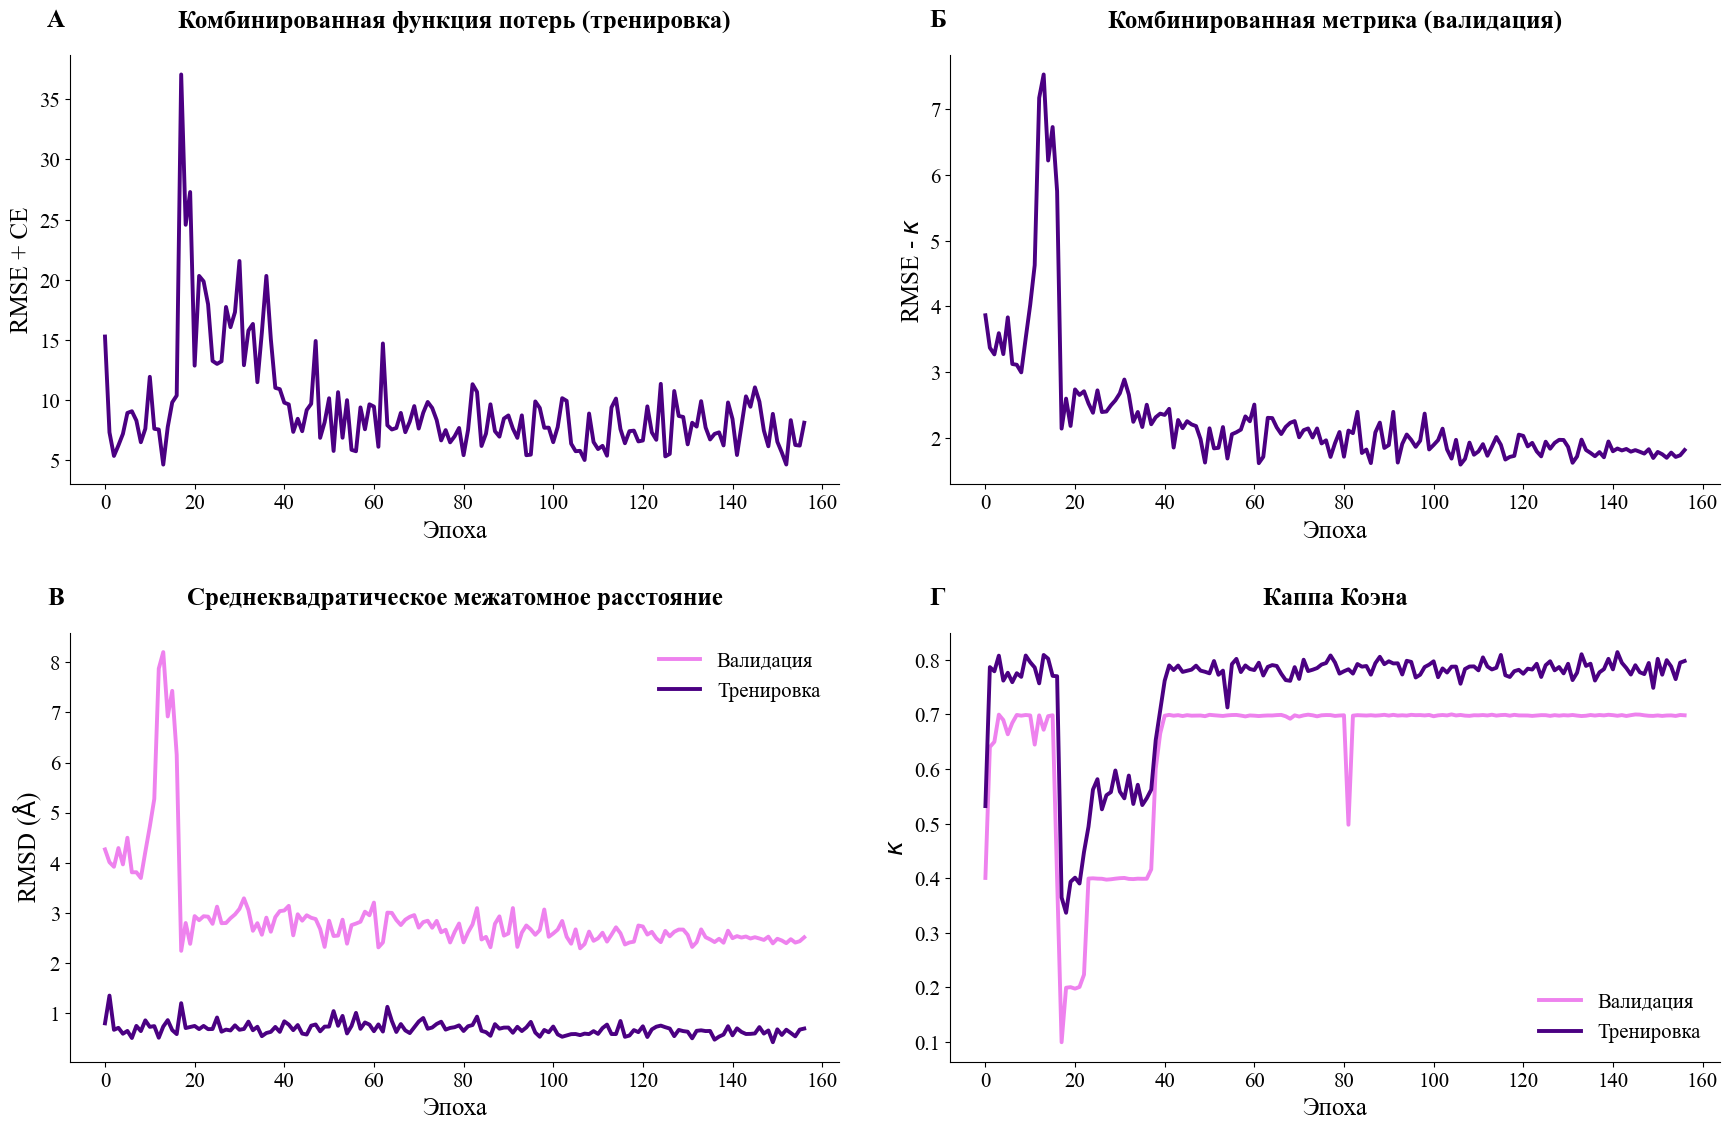

In [6]:
plt.rcParams['font.family'] = 'Times New Roman'


fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for ax in axes:
    ax.tick_params(axis='both', labelsize=15)
    sns.despine(ax=ax, top=True, right=True)

# Panel A: training loss.
train_loss_ax = axes[0]
sns.lineplot(
    data=wide_scalars,
    x='epoch',
    y='train_loss',
    color='indigo',
    linewidth=2.8,
    ax=train_loss_ax
)
train_loss_ax.set_title(
    'Комбинированная функция потерь (тренировка)',
    fontsize=18,
    fontweight='bold',
    pad=20
)
train_loss_ax.set_xlabel('Эпоха', fontsize=18)
train_loss_ax.set_ylabel('RMSE + CE', fontsize=18)

# Panel B: validation combined score with highlight.
val_score_ax = axes[1]
val_combined_score = scalars_by_epoch[scalars_by_epoch['tag'] == 'val_combined_score']
sns.lineplot(
    data=val_combined_score,
    x='epoch',
    y='value',
    color='indigo',
    linewidth=2.8,
    ax=val_score_ax
)
val_score_ax.set_title(
    'Комбинированная метрика (валидация)',
    fontsize=18,
    fontweight='bold',
    pad=20
)
val_score_ax.set_xlabel('Эпоха', fontsize=18)
val_score_ax.set_ylabel(r'RMSE - $\kappa$', fontsize=18)

# Panel C: RMSE for train vs validation.
rmse_ax = axes[2]
rmse_metrics = scalars_by_epoch[scalars_by_epoch['tag'].isin(['train_rmse', 'val_rmse'])].copy()
rmse_metrics['tag'] = rmse_metrics['tag'].map({'train_rmse': 'Тренировка', 'val_rmse': 'Валидация'})
sns.lineplot(
    data=rmse_metrics,
    x='epoch',
    y='value',
    hue='tag',
    palette=['violet', 'indigo'],
    linewidth=2.8,
    ax=rmse_ax
)
rmse_ax.set_title(
    'Среднеквадратическое межатомное расстояние',
    fontsize=18,
    fontweight='bold',
    pad=20
)
rmse_ax.set_xlabel('Эпоха', fontsize=18)
rmse_ax.set_ylabel(r'RMSD ($\mathrm{\AA}$)', fontsize=18)
rmse_ax.legend(title=None, fontsize=15, loc='upper right', frameon=False)

# Panel D: Cohen kappa for train vs validation.
kappa_ax = axes[3]
kappa_metrics = scalars_by_epoch[scalars_by_epoch['tag'].isin(['train_kappa', 'val_kappa'])].copy()
kappa_metrics['tag'] = kappa_metrics['tag'].map({'train_kappa': 'Тренировка', 'val_kappa': 'Валидация'})
sns.lineplot(
    data=kappa_metrics,
    x='epoch',
    y='value',
    hue='tag',
    palette=['violet', 'indigo'],
    linewidth=2.8,
    ax=kappa_ax
)
kappa_ax.set_title(
    'Каппа Коэна',
    fontsize=18,
    fontweight='bold',
    pad=20
)
kappa_ax.set_xlabel('Эпоха', fontsize=18)
kappa_ax.set_ylabel(r'$\kappa$', fontsize=18)
kappa_ax.legend(title=None, fontsize=15, loc='lower right', frameon=False)

fig.text(0.05, 0.954, 'А', fontsize=18, fontweight='bold', ha='center', va='center')
fig.text(0.54, 0.954, 'Б', fontsize=18, fontweight='bold', ha='center', va='center')
fig.text(0.05, 0.472, 'В', fontsize=18, fontweight='bold', ha='center', va='center')
fig.text(0.54, 0.472, 'Г', fontsize=18, fontweight='bold', ha='center', va='center')

fig.tight_layout(pad=3.2)
plt.show()

In [7]:
# Get paths from the latest run
log_dir = osp.join('..', 'logs')
latest_run_filename = sorted(os.listdir(log_dir))[-1]
latest_run_filename = 'dim512_steps200_lr5e-4_mse'
latest_run_dir = osp.join(log_dir, latest_run_filename)
ckpt_path = osp.join(latest_run_dir, 'checkpoints', 'last.ckpt')
test_dataset_path = osp.join(latest_run_dir, 'test_dataset.pt')

try:
    test_dataset = torch.load(test_dataset_path, weights_only=False)
except FileNotFoundError:
    print(f'Ошибка: Файл '{test_dataset_path}' не найден. Убедитесь, что тренировка успешно завершена.')

try:
    model = PytorchLightningModule.load_from_checkpoint(ckpt_path, map_location='cpu')
except FileNotFoundError:
    print(f'Ошибка: Файл `{ckpt_path}` не найден. Убедитесь, что вы запустили train.py и тренировка успешно завершилась.')

model = model.eval()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1886942894.py, line 12)

In [ ]:
original_full_graph = test_dataset[0]

# Create the condition graph based on the new autoregressive-friendly logic
# Condition: full left nucleotide, base of central, base of right.
is_left = original_full_graph.nucleotide_mask == 0
is_central = original_full_graph.central_mask
is_right = original_full_graph.nucleotide_mask == 2
is_base = ~original_full_graph.backbone_mask

condition_mask = is_left | (is_central & is_base) | (is_right & is_base)
condition_graph = original_full_graph.subgraph(condition_mask)

# Count number of nodes to generate (central backbone)
central_backbone_mask = original_full_graph.backbone_mask & original_full_graph.central_mask
num_nodes_to_generate = central_backbone_mask.sum().item()

# Generate the graph
generated_nodes, generated_pos, generated_edges = model.sample(
    condition_graph, num_nodes=num_nodes_to_generate
)

# Re-center the generated graph
original_centroid = original_full_graph.centroid
generated_pos = generated_pos + original_centroid

NameError: name 'test_dataset' is not defined

In [ ]:
idx_to_atom = {0: 'C', 1: 'N', 2: 'O', 3: 'P'}


def graph_to_cif_string(atom_types, pos):
    structure = Structure.Structure('generated_structure')
    model = PDBModel.Model(0)
    chain = Chain.Chain('A')
    residue = Residue.Residue((' ', 1, ' '), 'UNK', ' ')

    for i, (atom_type_idx, coord) in enumerate(zip(atom_types, pos)):
        atom_name = idx_to_atom.get(atom_type_idx, 'X')
        unique_atom_name = f'{atom_name}{i+1}'
        atom = Atom.Atom(
            name=unique_atom_name, coord=coord, bfactor=0, occupancy=1.0, altloc=' ',
            fullname=unique_atom_name, serial_number=i+1, element=atom_name.strip()
        )
        residue.add(atom)

    chain.add(residue)
    model.add(chain)
    structure.add(model)

    # Сохраняем в буфер в памяти вместо файла
    cif_io = StringIO()
    io = MMCIFIO()
    io.set_structure(structure)
    io.save(cif_io)
    return cif_io.getvalue()


generated_atom_types = torch.argmax(generated_nodes, dim=1).cpu().numpy()
generated_cif_data = graph_to_cif_string(generated_atom_types, generated_pos)

original_central_graph = original_full_graph.subgraph(central_backbone_mask)
orig_atom_types = torch.argmax(original_central_graph.x, dim=1).numpy()
orig_pos = (original_central_graph.pos + original_full_graph.centroid).numpy()
original_cif_data = graph_to_cif_string(orig_atom_types, orig_pos)

In [ ]:
# Localized molecular viewer labels for Russian audience.
view = py3Dmol.view(width=800, height=400, linked=False, viewergrid=(1, 2))

view.addModel(generated_cif_data, 'cif', viewer=(0, 0))
view.setStyle({'stick': {}}, viewer=(0, 0))
view.addLabel('Сгенерированная структура', {'fontColor': 'black', 'backgroundColor': 'lightgray', 'backgroundOpacity': 0.8}, viewer=(0, 0))

view.addModel(original_cif_data, 'cif', viewer=(0, 1))
view.setStyle({'stick': {}}, viewer=(0, 1))
view.addLabel('Исходная структура', {'fontColor': 'black', 'backgroundColor': 'lightgray', 'backgroundOpacity': 0.8}, viewer=(0, 1))

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from glob import glob

import matplotlib.pyplot as plt
import os.path as osp
import torch

# Load one processed graph sample.
processed_dir = osp.join('..', 'data', 'processed')
pt_files = sorted(glob(osp.join(processed_dir, '**', '*.pt'), recursive=True))
graph_path = pt_files[0]
graph = torch.load(graph_path, weights_only=False)

# Recover raw coordinates before alignment.
pos_aligned = graph.pos
origin = graph.origin.squeeze(0)
ref_frame = graph.ref_frame.squeeze(0)
pos_raw = pos_aligned @ ref_frame.T + origin

# Plot raw vs aligned coordinates on the same axes.
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_raw[:, 0], pos_raw[:, 1], pos_raw[:, 2], s=10, alpha=0.6, label='До выравнивания')
ax.scatter(pos_aligned[:, 0], pos_aligned[:, 1], pos_aligned[:, 2], s=10, alpha=0.6, label='После выравнивания')
ax.set_title('Граф до и после выравнивания')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

AttributeError: 'GlobalStorage' object has no attribute 'origin'